In [3]:
# required libraries
import pandas as pd
import numpy as np
import warnings

# ignore warnings
warnings.filterwarnings("ignore")

# For multiple line outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Lab 3 - Clustering
### Group_4 - Yang Zhang, Reannan McDaniel, Jonathon Roach, Fred Poon
### 8/1/2020
### MSDS_7331

# Table of contents
1. [Business Understanding](#business-understanding) <!-- 10 pts Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? -->
2. [Data Understanding 1](#data-understanding-1) <!-- 10 pts Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems? -->
3. [Data Understanding 2](#data-understanding-2) <!-- 10 pts Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs. -->
4. [Models and Evaluations](#model-evaluation)
    1. [Model and Evaluation 1 - train and parameters](#model-evaluation-1) <!-- 10 pts Train and adjust parameters -->   
    2. [Model and Evaluation 2 - evaluate and compare](#model-evaluation-2) <!-- 10 pts Evaluate and Compare -->    
    3. [Model and Evaluation 3 - visualize](#model-evaluation-3) <!-- 10 pts Visualize Results -->    
    4. [Model and Evaluation 4 - summarize](#model-evaluation-4) <!-- 20 pts Summarize the Ramifications -->    
5. [Deployment](#deployment) <!-- 10 pts Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? -->
6. [Exceptional Work](#exceptional-work) <!-- 10 pts You have free reign to provide additional analyses or combine analyses. -->

## Business Understanding <a name="business-understanding"></a>
For this analysis, our group will be working with North Carolina Public Schools Report Card and Statistical Profiles Data sets from the years 2014 to 2017. These data sets encompass information across 4 continuous years of educational attributes in North Carolina, USA.  The data is collected from the State of North Carolina at [https://www.dpi.nc.gov/](https://www.dpi.nc.gov/) and made available from the Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools by Dr. Jake Drew. Among other reasons, the data was collected for evaluation of public-school performance for the purpose of efficiently allocating funds to various educational initiatives. Analyses of such data are important because high-impact educational initiatives that are well-funded contribute to increased graduation rates, increased achievement at the post-secondary level, less crime, and greater economic engagement among young people. For the purpose of this exercise, our focus is on predicting graduation rates using various school characteristics, such as type of school (elementary, middle, high, or some combination of the three), social demographics, economic demographics, and location between 2014 and 2017. The Belk Foundation's website says, "Our goal is to empower today’s workforce by creating pathways to and through postsecondary education for underrepresented students".

For the sake of this analysis, we assume that better performing schools have better outcomes in postsecondary education. With North Carolina's rapidly changing demographics, it is important to take into consideration schools' unique needs when allocating funds to strategic investment initiatives. Here, we explore where funding can be best applied based on educational achievement data.

We will explore through visual and mathematical modeling which features best predict the graduation rate. The analysis will come in a combination of classification models to predict. In this analysis we will observe:

- What classification model provides the higher accuracy score?
- What regression model provides a better MAE score?

## Data Understanding - knowing the data <a name="data-understanding-1"></a>

In [6]:
# read in CSV
df2014 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2014_MLnew.csv')
df2015 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2015_MLnew.csv')
df2016 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2016_MLnew.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2017_MLnew.csv')

df2014.shape
df2015.shape
df2016.shape
df2017.shape

df2014['Year'] = 2014
df2015['Year'] = 2015 
df2016['Year'] = 2016 
df2017['Year'] = 2017

frames = [df2014, df2015, df2016, df2017]
df_comb_test = pd.concat(frames,join='inner', ignore_index=True)

df_comb_test.info()

(2426, 318)

(2432, 335)

(2430, 328)

(2443, 328)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 259 entries, vphone_ad to Year
dtypes: float64(237), int64(2), object(20)
memory usage: 19.2+ MB


In [7]:
schoolData = df_comb_test

#Locate the categorical variables in dataset
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
uniqueThreshold = 25

#Delete categorical columns with > 25 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = schoolData[sD_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
schoolData.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

#Review dataset contents one hot high unique value drops
print('*********After: Removing columns with >= uniqueThreshold unique values***********')
schoolData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(oneHotUniqueValueCols))

*********After: Removing columns with >= uniqueThreshold unique values***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 250 entries, szip_ad to Year
dtypes: float64(237), int64(2), object(11)
memory usage: 18.6+ MB

Columns Deleted:  9


In [8]:
#Keep an original copy of the Data
schoolData_org = schoolData

#Pop out the SPG information from the Data
schoolData_SPG = schoolData.pop('SPG Grade')
schoolData_SPGScore = schoolData.pop('SPG Score')

# Remove All the Columns that directly used to calculate SPG Grade and Score
schoolData.drop(schoolData.iloc[:, 21:162], inplace=True, axis=1)
schoolData.info(verbose=True)

#Isolate remaining categorical variables
begColumnCt = len(schoolData.columns)

#one hot encode categorical variables
schoolData = pd.get_dummies(data=schoolData,drop_first=True)

#Determine change in column count
endColumnCt = len(schoolData.columns)
columnsAdded = endColumnCt - begColumnCt

#Review dataset contents one hot high unique value drops
print('Columns To One-Hot Encode: ', len(sD_nominal.columns))
print('\r\n*********After: Adding New Columns Via One-Hot Encoding*************************')
schoolData.info(verbose=False)
print ('\r\nNew Columns Created Via One-Hot Encoding: ', columnsAdded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 107 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   szip_ad                              float64
 1   category_cd                          object 
 2   calendar_type_txt                    object 
 3   sna_pgm_type_cd                      object 
 4   school_type_txt                      object 
 5   calendar_only_txt                    object 
 6   title1_type_cd                       object 
 7   esea_status                          object 
 8   student_num                          float64
 9   lea_avg_student_num                  float64
 10  st_avg_student_num                   float64
 11  Grad_project_status                  object 
 12  Math I_Size                          float64
 13  lea_total_expense_num                float64
 14  lea_salary_expense_pct               float64
 15  lea_services_expense_pct             

In [9]:
# Random Forest apply to X with all variables
from sklearn.ensemble import RandomForestClassifier
clfa=RandomForestClassifier(n_estimators=100)
clfa.fit(schoolData,schoolData_SPG)
y_pred=clfa.predict(schoolData)

#For feature importance from RandomForestClassifier()
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clfa, random_state=1).fit(schoolData,schoolData_SPG)
eli5.show_weights(perm, feature_names = schoolData.columns.tolist(), top=50)

RandomForestClassifier()

Weight,Feature
0.0419 ± 0.0036,TotalTargets_pTarget_PctMet
0.0038 ± 0.0006,MinorityFemalePct
0.0033 ± 0.0004,short_susp_per_c_num
0.0020 ± 0.0005,MinorityMalePct
0.0016 ± 0.0004,title1_type_cd_Y
0.0010 ± 0.0003,BlackMalePct
0.0007 ± 0.0002,AsianFemalePct
0.0006 ± 0.0003,BlackFemalePct
0.0006 ± 0.0002,MathGr3-8_pTarget_PctMet
0.0005 ± 0.0002,nbpts_num


In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = schoolData_Y
X = schoolData_X
cv = StratifiedKFold(n_splits=3)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

In [10]:
schoolData_X_sub = schoolData_X[['TotalTargets_pTarget_PctMet','MinorityFemalePct','short_susp_per_c_num','MinorityMalePct',
                                 'title1_type_cd_Y','BlackMalePct','AsianFemalePct','BlackFemalePct','MathGr3-8_pTarget_PctMet','nbpts_num']]


for train_indices, test_indices in cv_object_reg.split(schoolData_X_sub,schoolData_Y): 
    
    X_train = schoolData_X_sub.values[train_indices]
    y_train = schoolData_Y.values[train_indices]
    
    X_test = schoolData_X_sub.values[test_indices]
    y_test = schoolData_Y.values[test_indices]

NameError: name 'schoolData_X' is not defined

## Data Understanding - visualizing the data <a name="data-understanding-2"></a>

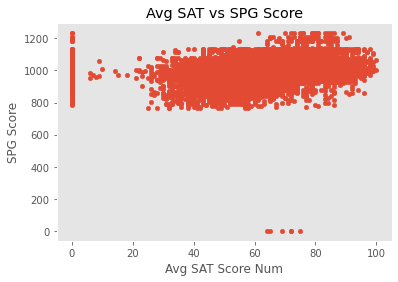

In [21]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = schoolData[['lea_sat_avg_score_num','SPG Score']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Avg SAT Score Num'), plt.ylabel('SPG Score')
plt.grid()
plt.title('Avg SAT vs SPG Score')
plt.show()

## Models and Evaluations - Clustering <a name="model-evaluation"></a>

### Train and Parameter Tuning <a name="model-evaluation-1"></a>

### Evaluate and Compare <a name="model-evaluation-2"></a>

### Cluster Visualization <a name="model-evaluation-3"></a>

### Summary <a name="model-evaluation-4"></a>

## Deployment

## Exceptional Work